# Regression Models and Feature Selections

## Load Data

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
%matplotlib inline

In [49]:
train = pd.read_csv("train.csv")
train.drop('Id', axis = 1, inplace = True)
train = train[train.SalePrice <= 520000]
test = pd.read_csv("test.csv").drop("Id", axis = 1)
train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [50]:
all_data = pd.concat([train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass':'SaleCondition']])

In [51]:
all_data.shape

(2911, 79)

## Data preprocessing:

We're not going to do anything fancy here:
* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns

In [52]:
train["SalePrice"] = np.log1p(train["SalePrice"]) ## np.log1p(x) = log(x+1)

# log transform skewed numeric features:
numeric_feats = all_data.select_dtypes(exclude = ['object']).columns.values
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
#over_skewed_feats = skewed_feats[abs(skewed_feats) > 9].index
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75].index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [53]:
all_data = pd.get_dummies(all_data)

In [54]:
all_data = all_data.fillna(all_data.mean())

In [55]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Lasso Model

In [56]:
from sklearn.linear_model import ElasticNet, LassoCV
from sklearn.cross_validation import cross_val_score

In [57]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = "mean_squared_error", cv = 5))
    return (rmse)

In [58]:
def predict(model, test_data, filename):
    ypred = model.predict(test_data)
    submission = pd.read_csv("sample_submission.csv")
    submission['SalePrice'] = np.expm1(ypred)
    submission.to_csv(filename, index = False)

In [59]:
alphas = [0.0001, 0.0005, 0.001, 0.003, 0.01, 0.03, 0.1, 1]
model_lasso = LassoCV(alphas = alphas, n_jobs= -1, max_iter = 2000, cv = 5).fit(X_train, y)

In [60]:
rmse_cv(model_lasso, X_train, y).mean()

0.12132467597640488

In [61]:
ypred = model_lasso.predict(X_test)
submission = pd.read_csv("sample_submission.csv")
submission['SalePrice'] = np.expm1(ypred)
submission.to_csv("lasso_3.csv", index = False)

In [62]:
cf = pd.DataFrame({'features': X_train.columns.values, 'coef': model_lasso.coef_})

In [63]:
dropped_features = cf[cf.coef == 0].features.values
print "In total, %s features have been dropped. " %len(dropped_features)

In total, 179 features have been dropped. 


In [64]:
selected_features = cf[cf.coef > 0].features.values

### Scale the features before training (Robust Scaler)

In [65]:
from sklearn.preprocessing import RobustScaler

In [66]:
robust_scaler = RobustScaler()
scale_data = robust_scaler.fit_transform(all_data)

In [67]:
X_train = scale_data[:train.shape[0], ]
X_test = scale_data[train.shape[0]:, ]

In [68]:
model_lasso = LassoCV(alphas=alphas, n_jobs = -1, max_iter = 2000, cv = 5).fit(X_train, y)

In [69]:
rmse_cv(model_lasso, X_train, y).mean()

0.12157733362133112

In [70]:
predict(model_lasso, X_test, filename="lasso_rs.csv")

In [71]:
cf = pd.DataFrame({'features': all_data.columns.values, 'coef': model_lasso.coef_})
dropped_features = cf[cf.coef == 0].features.values
print "In total, %s features have been dropped. " %len(dropped_features)

In total, 178 features have been dropped. 


In [72]:
dropped_features

array(['LotFrontage', 'MasVnrArea', '2ndFlrSF', 'BsmtHalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'MoSold',
       'MSZoning_RH', 'MSZoning_RL', 'Street_Grvl', 'Street_Pave',
       'Alley_Grvl', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS',
       'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub',
       'Utilities_NoSeWa', 'LotConfig_FR3', 'LotConfig_Inside',
       'LandSlope_Gtl', 'LandSlope_Sev', 'Neighborhood_Blmngtn',
       'Neighborhood_Blueste', 'Neighborhood_BrDale',
       'Neighborhood_CollgCr', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV',
       'Neighborhood_NPkVill', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_PosA',
       'Condition1_PosN', 'Condition1_RRAn', 'Condition1_RRNe',
       'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr',
       'Condition2_Norm', 'Condition2_PosA', 

In [73]:
cf['abs_coef'] = np.abs(cf['coef'])
cf = cf.sort_values(by = ['abs_coef'], ascending = False)
cf = cf[cf.coef != 0].iloc[0: 20, :]

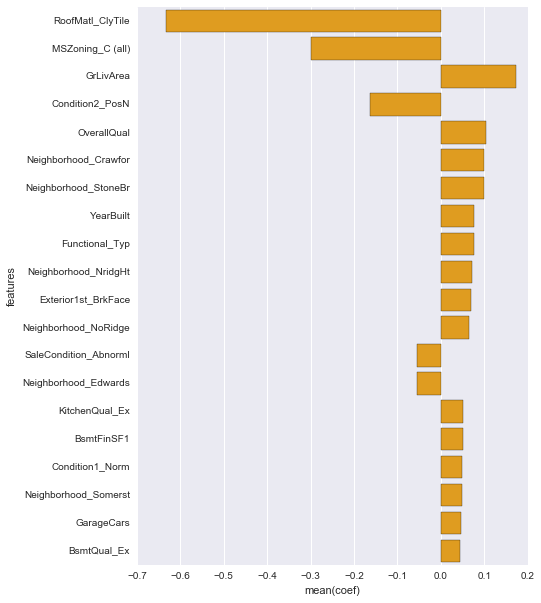

In [74]:
plt.figure(figsize = (7, 10))
sns.barplot('coef', 'features', data = cf, orient= 'h', color = 'orange')
#xt = plt.xticks(rotation=45)

## Kernel Ridge Regression

In [75]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cross_validation import cross_val_predict

In [76]:
# define the scoring function
def rmse_score(y_true, y_pred):
    score = np.sqrt(mean_squared_error(y_true, y_pred))
    return score
rmse = make_scorer(rmse_score, greater_is_better=False)

** 
Using the selected the features from Lasso models
**

In [77]:
selected_data = all_data[selected_features]
#scaled_selected_data = robust_scaler.fit_transform(selected_data)
X_train = selected_data[:train.shape[0]]
X_test = selected_data[train.shape[0]:]

### Linear Kernel

In [78]:
kr_linear = KernelRidge(kernel = 'linear')#.fit(X_train, y)
grid_kr_linear = GridSearchCV(kr_linear, param_grid = {'alpha': [0.1, 1, 3, 10, 30, 50, 100]}, 
                              cv = 5, n_jobs = -1, verbose = 1, scoring = rmse).fit(X_train, y)
rmse_cv(grid_kr_linear.best_estimator_, X_train, y).mean()

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.0s finished


0.12250814846133573

In [79]:
predict(grid_kr_linear.best_estimator_, X_test, "kn_linear.csv")

## RBF Kernel

In [80]:
# Scale the features using RobustScaler
scaled_selected_data = robust_scaler.fit_transform(selected_data)
X_train = scaled_selected_data[:train.shape[0], ]
X_test = scaled_selected_data[train.shape[0]:, ]

In [81]:
kr_rbf = KernelRidge(kernel = 'rbf')
param_grid = {'alpha': np.logspace(-5, -2, 10), 
              'gamma': np.logspace(-7, -2, 10)}
grid_kr = GridSearchCV(kr_rbf, cv = 5, param_grid=param_grid, n_jobs = -1, 
                       verbose = 1, scoring = rmse).fit(X_train, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   14.0s finished


In [82]:
kr_rbf_model = grid_kr.best_estimator_
print "The best score is %s" %-grid_kr.best_score_
print "The best parameters are %s" % grid_kr.best_params_

The best score is 0.11969538387
The best parameters are {'alpha': 0.0001, 'gamma': 0.00021544346900318845}


In [83]:
scores = pd.DataFrame(grid_kr.grid_scores_)
scores = scores.rename(columns={'mean_validation_score': 'rmse'})
scores['alpha'] = scores['parameters'].apply(lambda x: x['alpha'])
scores['gamma'] = scores['parameters'].apply(lambda x: x['gamma'])
scores.drop(labels = ['cv_validation_scores', 'parameters'], axis = 1, inplace = True)

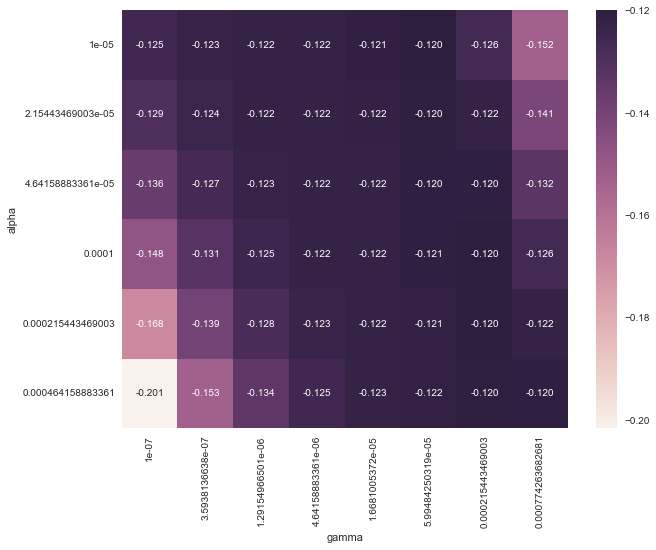

In [84]:
plt.figure(figsize=(10, 7.5))
sns.heatmap(scores[(scores.alpha < 0.001) & (scores.gamma < 0.001)].pivot('alpha', 'gamma', 'rmse'), 
            annot=True, fmt = ".3f", cmap=None)

In [85]:
predict(kr_rbf_model, X_test, 'kr_rbf.csv')

### Polynomial Kernel

In [86]:
scaled_selected_data = robust_scaler.fit_transform(selected_data)
X_train = scaled_selected_data[:train.shape[0], ]
X_test = scaled_selected_data[train.shape[0]:, ]

In [87]:
kr_plyn = KernelRidge(kernel = 'polynomial')
param_grid = {'degree': [2, 3, 4], 
              'alpha': [1, 3, 10, 30, 40, 50],
              #'coef0': np.logspace(-1, 4, 6)
              'coef0': [9, 10, 11, 12, 15]
             }
grid_plyn = GridSearchCV(kr_plyn, cv = 5, param_grid=param_grid, n_jobs = -1, 
                         verbose = 1, scoring = rmse).fit(X_train, y)

print "The best score is %s" %-grid_plyn.best_score_
print "The best parameters are %s" % grid_plyn.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.4s


The best score is 0.11851567362
The best parameters are {'alpha': 10, 'coef0': 9, 'degree': 3}


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   14.2s finished


In [88]:
kr_plyn_model = grid_plyn.best_estimator_
predict(kr_plyn_model, X_test, 'kr_plyn_model.csv')

**
So far, polynomial KernelRridge Regression works the best.
**

## ElasticNet

In [89]:
#X_train = all_data[:train.shape[0]]
#X_test = all_data[train.shape[0]:]
scaled_all_data = RobustScaler().fit_transform(all_data)
X_train = scaled_all_data[:train.shape[0], ]
X_test = scaled_all_data[train.shape[0]:, ]

In [90]:
elanet = ElasticNet()
param_grid = {'alpha': [0.0001, 0.001, 0.003, 0.01],
              'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.75, 1]
             }
grid_ela = GridSearchCV(elanet, cv = 5, param_grid = param_grid, n_jobs = -1, 
                        scoring = rmse, verbose = 1).fit(X_train, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.9s finished


In [91]:
print "The best scoring is %.6f" %-grid_ela.best_score_
print "The best hyper-parameters are %s" %grid_ela.best_params_

The best scoring is 0.121763
The best hyper-parameters are {'alpha': 0.001, 'l1_ratio': 0.5}


In [92]:
scores = pd.DataFrame(grid_ela.grid_scores_)
scores.rename(columns={'mean_validation_score': 'rmse'}, inplace = True)
scores['alpha'] = scores['parameters'].apply(lambda x: x['alpha'])
scores['l1_ratio'] = scores['parameters'].apply(lambda x: x['l1_ratio'])
scores.drop(labels = ['parameters', 'cv_validation_scores'], axis = 1, inplace = True)

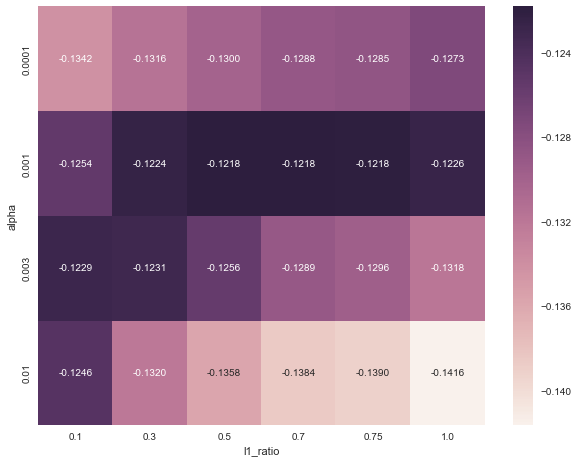

In [93]:
plt.figure(figsize=(10, 7.5))
sns.heatmap(scores.pivot('alpha', 'l1_ratio', 'rmse'), annot=True, fmt = ".4f")

In [94]:
predict(grid_ela, X_test, 'elasticNet.csv')